In [23]:
"""
To get started, we provide a simple example of how to use the API to generate 10 int16 random numbers.
In particular, observe where we pass in the min and max parameters to specify the range of random numbers we want
and the quantity parameter to specify how many random numbers we want.
Here is the API KEY you will need to use: aTo4BKRvnc49uRWDk034zaua87vGRXKk9TMLdfkI
"""
from requests import get
from time     import perf_counter_ns

import numpy as np
import matplotlib.pyplot as plt

from aes.aes_impl import encrypt_message_aes_cbc

## Task 3: Quest for Quantum Randomness

### Part A: Truly Different

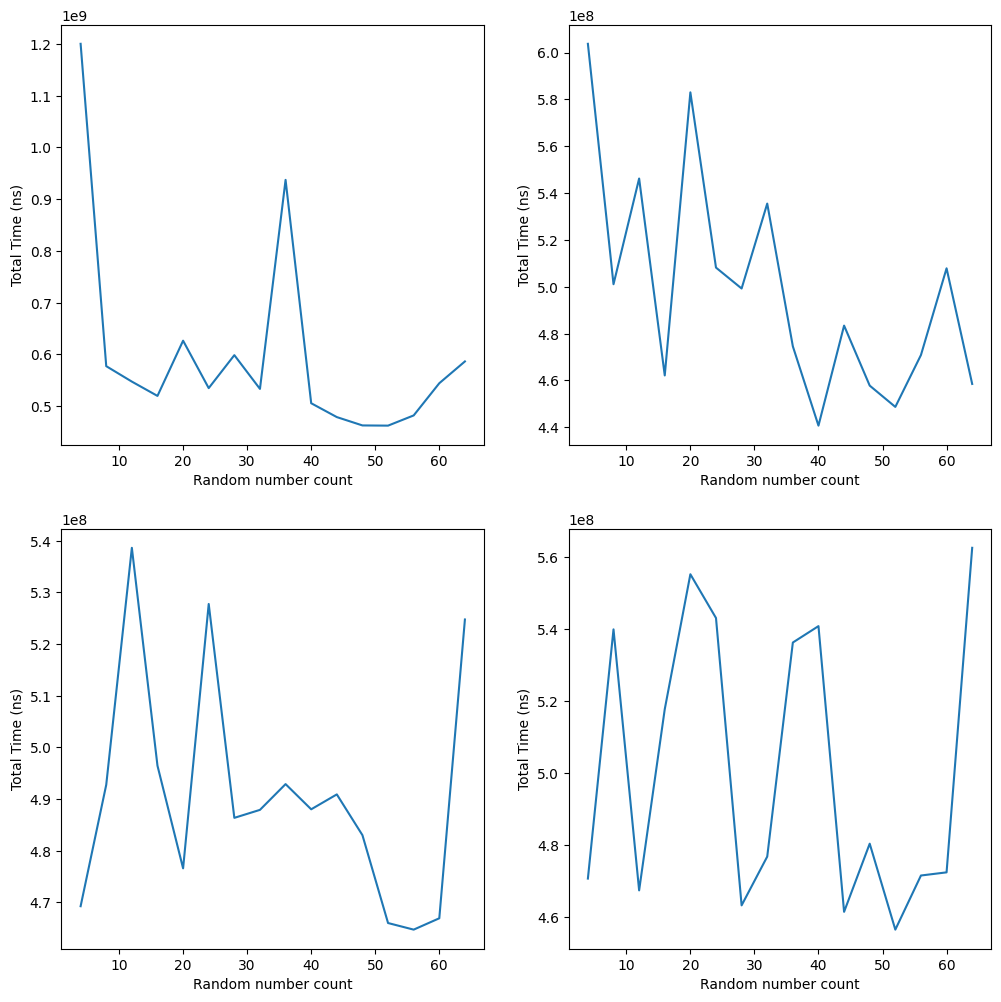

In [25]:
def api_call_qrng(quantity):
    """
    Fetches random numbers from the QRNG API.

    Args:
        quantity (int): Number of random values to fetch.

    Returns:
        dict: A dictionary with keys ('data', 'dataType').
    """
    if quantity < 0 or quantity > 64:
        raise ValueError('Quantity must be between 0 and 64')

    response = get("https://qrng.idqloud.com/api/1.0/short",
                   headers={"X-API-KEY": 'aTo4BKRvnc49uRWDk034zaua87vGRXKk9TMLdfkI'},
                   params={"quantity": quantity})
    response.raise_for_status()
    result = response.json()
    return {
        "data": result.get("data"),
        "dataType": result.get("dataType")
    }


def plot_api_call_lags():
    """
    Four times, this method will fetch 4 to 64 random numbers from the QRNG API.
    We plot the times taken for each of those four cases in four seperate graphs.
    """
    # It appears the that times are not linear in the number of random numbers
    # requested, as such we have no way of eliminating the API lag while measuring
    # the bit rate. Computations done later will reflect this.

    plt.figure(figsize=(12, 12))

    for i in range(1, 5):
        plt.subplot(2, 2, i)
        times = []
        for i in range(16):
            t_start = perf_counter_ns()
            api_call_qrng(4 * (i + 1))
            t_elapsed = perf_counter_ns() - t_start
            times.append(t_elapsed)

        plt.xlabel("Random number count")
        plt.ylabel("Total Time (ns)")
        plt.plot(list(range(4, 65, 4)), times)
    plt.show()


plot_api_call_lags()


QRNG bitrate: 2128.414589, AES bitrate: 1679084.737188.


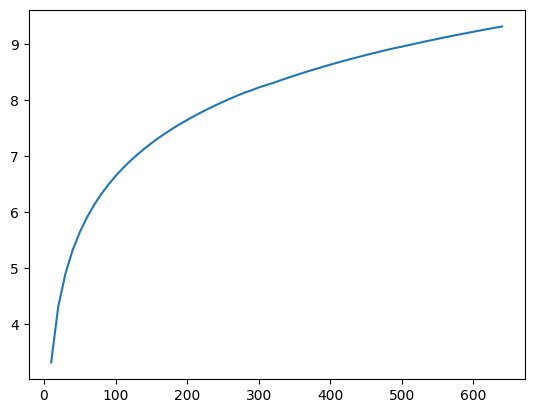

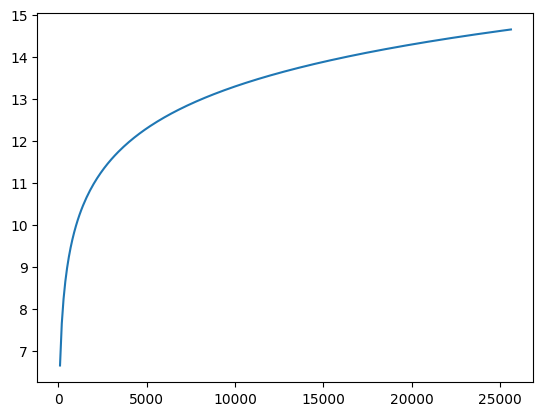

In [28]:

"""
You can paste the other environmental entropy based TRNGs from Task 2 and compare the performance
Compare your written QRNG to the previous TRNGs. Be sure to compare them with respect to bitrate and entropy.
"""
def compute_entropy(rand_array: np.ndarray,
                    elements_to_consider: int,
                    use_shannon: bool = False) -> float:
    """
    Computes the entropy of an array containing the sequential outputs of an
    randomly generated array while only considering the first
    ``elements_to_consider`` elements of the array. Based on the ``use_shannon``
    parameter, this function returns either the Shannon entropy or the Min
    entropy (default).
    """
    rand_array = rand_array[:elements_to_consider]
    random_variable_probabilities = \
        np.unique(rand_array, return_counts=True)[1] / len(rand_array)

    if not use_shannon:
        # Use Min entropy.
        return -np.log2(np.max(random_variable_probabilities))

    return np.sum(random_variable_probabilities * -np.log2(random_variable_probabilities))


def plot_entropy(sequence: np.ndarray, increment: int, use_shannon: bool = False) -> None:
    """
    Plots the entropies of subsequences of the given sequence. The first
    subsequence captures the first ``increment`` elements of the given sequence,
    and each subsequent subsequence captures the next ``increment`` elements of
    the given sequence after the last element covered by its predecessor.

    :param sequence:    The sequence whose step-wise entropy is to be plotted.
    :param increment:   The length of each of the steps.
    :param use_shannon: Whether to use Shannon entropy or the Min entropy (default).
    """
    x_indices = []
    y_indices = []
    for n in range(increment, len(sequence) + 1, increment):
        entropy = compute_entropy(sequence, n, use_shannon=use_shannon)
        x_indices.append(n)
        y_indices.append(entropy)

    plt.plot(x_indices, y_indices)
    plt.show()


def aes_pseudo_rng(seed: bytes, num_bytes: int) -> list[bytes]:
    """
    Generates a sequence of pseudo-random bytes using the AES algorithm.

    :param seed: The seed to provide to the AES algorithm.
    :param num_bytes: The number of bytes to generate.

    :return: A list of length-1 byte strings. Each element of this list
             is a pseudo-random byte.
    """
    # One run of the AES generates 16 random bytes, assuming the input length is
    # less than 16 bytes. We will assume that the integers we provide it would
    # be shorter than 16 bytes, since its unlikely that our users will ask for
    # more than 16 * 2^128 bytes to be generated.
    num_iter = num_bytes // 16

    # The AES encryption itself provides the pseudo-randomness, so providing a
    # simple counter is sufficient. Note that this leads to the CTR mode of AES,
    # but we do not use that here.

    # 4 bytes should be enough to cover num_iter, the implementation will pad
    # this ot the needed 16 bytes.
    return [encrypt_message_aes_cbc(i.to_bytes(4), seed)
            for i in range(num_iter)]


def get_rng_and_time_metrics(use_qrng, bytes_to_generate, iterations):
    """
    We generate 128 random bits using either the classical (AES based) or QRNG
    randomizer (as per the ``use_qrng`` arg) ``iterations`` number of times.
    Then we return the avg and standard deviation of the times taken / byte.

    :param iterations: The number of times to generate random numbers.
    """
    if use_qrng and bytes_to_generate > 128:
        raise ValueError('The number of bytes to generate must be less than 128 '
                         'if we are using a QRNG as their API call does not support '
                         'querying more than 64 random shorts.')

    time_s = []
    rngs = []
    for _ in range(iterations):
        start_time = perf_counter_ns()
        if use_qrng:
            rngs.extend(api_call_qrng(bytes_to_generate // 2)["data"])
        else:
            rngs.extend(aes_pseudo_rng(np.random.bytes(16), bytes_to_generate))
        time_s.append((perf_counter_ns() - start_time)  / 1e9)

    # Avg after removing min and max extremes.
    # We do this because the first API call sometimes takes too long.
    sorted_time_s = sorted(time_s)
    trimmed_time_s = np.array(sorted_time_s[1:-1])

    trimmed_time_s /= bytes_to_generate

    return np.array(rngs), np.average(trimmed_time_s), np.std(trimmed_time_s)


qrng, qrng_avg_s, qrng_std_s = get_rng_and_time_metrics(True,    0x80,  10)
aes,  aes_avg_s,  aes_std_s  = get_rng_and_time_metrics(False, 0x1000, 100)

qrng_bitrate = 8 / qrng_avg_s
aes_bitrate  = 8 / aes_avg_s

print(f"QRNG bitrate: {qrng_bitrate:2f}, AES bitrate: {aes_bitrate:2f}.")

plot_entropy(qrng, 10, use_shannon=True)
plot_entropy(aes, 100, use_shannon=True)

### Part B: Easy as Pi!

In [27]:
"""
Implement the Monte Carlo algorithm for estimating Pi using your various sources of randomness. 

If you are stuck on how to implement the algorithm: 
https://www.geeksforgeeks.org/estimating-value-pi-using-monte-carlo/
"""
def estimate_pi():
    pass